In [13]:
import os
import json
from torchvision import models, transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

# Definiowanie folderu zawierającego obrazy testowe
test_folder = '/content/drive/MyDrive/ProjektOwoce/testing'
output_file = '/content/drive/My Drive/ProjektOwoce/data/predicted_annotations2.json'

# Modele, które będą używane
model_names = ["AlexNet", "DenseNet", "EfficientNet", "ResNet", "MobileNet V3"]

# Predefiniowane transformacje obrazów
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Zmiana rozmiaru obrazu do 224x224
    transforms.ToTensor(),  # Konwersja obrazu do tensora
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja
])

# Wczytanie klas ImageNet
with open("/content/drive/MyDrive/ProjektOwoce/data/imagenet-classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# Dynamiczne ładowanie modeli z torchvision.models
models_dict = {
    "AlexNet": models.alexnet(pretrained=True),
    "DenseNet": models.densenet121(pretrained=True),
    "EfficientNet": models.efficientnet_b0(pretrained=True),
    "ResNet": models.resnet50(pretrained=True),
    "MobileNet V3": models.mobilenet_v3_large(pretrained=True),
}

# Sprawdzenie, czy dostępna jest karta graficzna CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Przygotowanie słownika do przechowywania predykcji dla wszystkich modeli
all_model_predictions = {}

# Przetwarzanie każdego modelu
for model_name, model in models_dict.items():
    print(f"\nUsing model: {model_name}")

    model = model.to(device)
    model.eval()

    # Wczytanie wszystkich obrazów z folderu
    images = []
    image_names = []
    for image_name in os.listdir(test_folder):
        image_path = os.path.join(test_folder, image_name)
        try:
            image = Image.open(image_path).convert('RGB')
            images.append(image)
            image_names.append(image_name)
        except Exception as e:
            print(f"Error loading image {image_name}: {e}")

    # Tworzenie predykcji dla wszystkich obrazów
    predictions = []
    for image_name, image in zip(image_names, images):
        try:
            input_tensor = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
            _, predicted_idx = torch.max(output, 1)
            predicted_class = predicted_idx.item()
            label = imagenet_classes[predicted_class]
            predictions.append({"filename": image_name, "predicted_label": label})
        except Exception as e:
            predictions.append({"filename": image_name, "predicted_label": "Error"})
            print(f"Error while processing the image{image_name}: {e}")

    # Zapisanie predykcji dla bieżącego modelu
    all_model_predictions[model_name] = predictions

    # Wyświetlanie wszystkich obrazów z predykcjami
    cols = 9
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    fig.suptitle(f"Predictions {model_name}", fontsize=16)

    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(predictions[i]['predicted_label'], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Zapisanie wszystkich predykcji do pliku JSON
with open(output_file, 'w') as f:
    json.dump(all_model_predictions, f, indent=4)

print(f"Predictions saved to {output_file}")


Output hidden; open in https://colab.research.google.com to view.

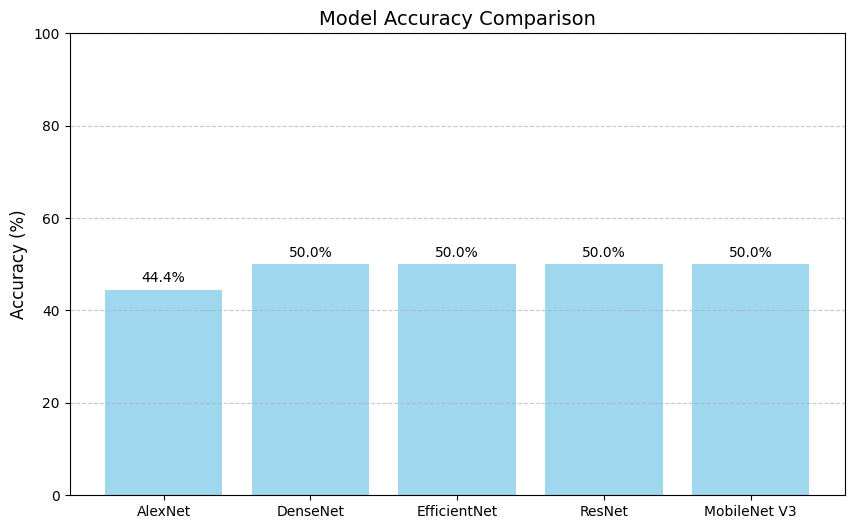

In [9]:
import json
import matplotlib.pyplot as plt

# Ścieżki do plików
true_annotations_path = '/content/drive/MyDrive/ProjektOwoce/true_annotations.json'
predicted_annotations_path = '/content/drive/MyDrive/ProjektOwoce/predicted_annotations2.json'

# Wczytaj dane
with open(true_annotations_path, 'r') as f:
    true_data = json.load(f)

with open(predicted_annotations_path, 'r') as f:
    predicted_data = json.load(f)

# Funkcja do mapowania prawdziwych etykiet
true_labels = {entry["filename"]: entry["labels"][0] for entry in true_data}

# Funkcja do obliczenia dokładności
def calculate_accuracy(predictions, true_labels):
    correct = 0
    total = 0
    for pred in predictions:
        filename = pred["filename"]
        predicted_label = pred["predicted_label"].lower()
        if filename in true_labels:
            true_label = true_labels[filename].lower()
            if predicted_label == true_label:
                correct += 1
            total += 1
    return (correct / total) * 100 if total > 0 else 0

# Oblicz dokładności dla każdego modelu
models = list(predicted_data.keys())
accuracies = []
for model in models:
    predictions = predicted_data[model]
    accuracy = calculate_accuracy(predictions, true_labels)
    accuracies.append(accuracy)

# Wykres porównawczy
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color='skyblue', alpha=0.8)

# Dodanie procentowych wartości nad słupkami
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{accuracy:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, 100)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Model Accuracy Comparison", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
